# Credit Fraud Detection

## The objective is to create and compare models that will help us detect credit fraud, these models will be judged on accuracy, precision, recall and their f-1 score

### The dataset contains transactions made by credit cards in September 2013 by European cardholders and contains only numerical input variables which are the result of a principal component analysis transformation. Unfortunately, due to confidentiality issues, the original features are not provided

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

random.seed(42)



In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.isna().sum().sum()

0

In [5]:
df_a = df.loc[:, ['Time', 'Amount', 'Class']]

In [6]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   Amount  284807 non-null  float64
 2   Class   284807 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 6.5 MB


In [7]:
df_a.head()

,Time,Amount,Class
0,0.0,149.62,0
1,0.0,2.69,0
2,1.0,378.66,0
3,1.0,123.50,0
4,2.0,69.99,0


In [8]:
df_a.describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [9]:
print('Average amount')

Average amount


In [10]:
df_a.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

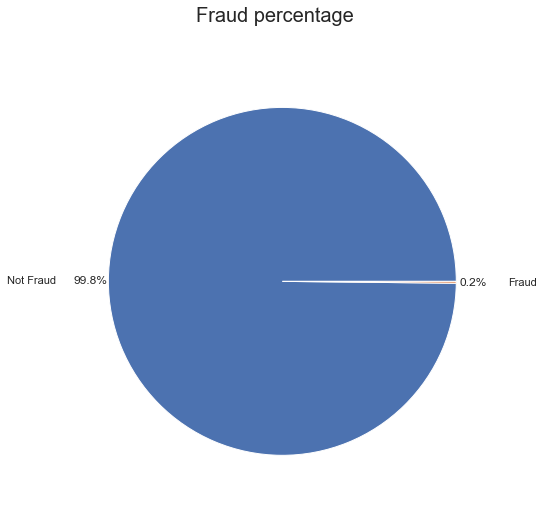

In [11]:
fraud = df_a.Class.value_counts()[0]
not_fraud = df_a.Class.value_counts()[1]

labels = ['Not Fraud' , 'Fraud']
sizes = [fraud, not_fraud]

plt.figure(figsize=(8,8))
plt.suptitle("Fraud percentage", fontsize= 20)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow= False, labeldistance= 1.3, pctdistance= 1.1);

### Splitting the dataframe into test and train data

In [12]:

train_data, test_data = train_test_split(df, test_size= 0.25)

### Determining the features and result for the test data

In [13]:
X_test = test_data.drop('Class', axis = 1)
y_test = test_data.Class

## Bootstrapping for equal number of samples
#### As fraud is is only 0.2% of the population therefore it's imbalanced and accuracy has problems with imbalanced classes 

In [14]:
fraud = train_data[train_data.Class == 1]
not_fraud = train_data[train_data.Class == 0]

upsampling_fraud = resample(fraud, replace=True, n_samples= len(not_fraud), random_state=42)
upsampled_data = pd.concat([not_fraud, upsampling_fraud])

upsampled_data.Class.value_counts()

0    213241
1    213241
Name: Class, dtype: int64

With so few positives relative to negatives, the training model will spend most of its time on negative examples and not learn enough from positive ones. Therefore we bootstrapped the data to make it balanced

### Determining the features and result for the train data

In [15]:
X_train = upsampled_data.drop('Class', axis = 1)
y_train = upsampled_data.Class

## Random Forest

In [16]:
rf = RandomForestClassifier(n_estimators = 20)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print('Random Forest')
accuracy_score(y_test ,rf_pred), recall_score(y_test ,rf_pred), precision_score(y_test ,rf_pred), f1_score(y_test ,rf_pred)

Random Forest


(0.9994663071262043, 0.734375, 0.9591836734693877, 0.831858407079646)

### Determining which features are the most important

In [17]:
rf_model.feature_importances_

array([0.0039205 , 0.00607483, 0.02715393, 0.03512418, 0.05473956,
       0.01051934, 0.02141271, 0.03028343, 0.00966158, 0.03000034,
       0.23380526, 0.01229305, 0.12241857, 0.00651463, 0.16030626,
       0.00636968, 0.02335164, 0.09313063, 0.02391935, 0.01330689,
       0.01215829, 0.00845391, 0.00560353, 0.00820944, 0.00489423,
       0.00450767, 0.01015438, 0.00740874, 0.00766778, 0.00663567])

## Logistic Regression

In [18]:
lr = LogisticRegression(max_iter= 1000)
lr_model = lr.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print('Logistic Regression')
accuracy_score(y_test ,lr_pred), recall_score(y_test ,lr_pred), precision_score(y_test ,lr_pred),f1_score(y_test ,lr_pred)

Logistic Regression


(0.9670795764163927, 0.90625, 0.04738562091503268, 0.09006211180124223)

## Gaussian Naive Bayes

In [19]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
accuracy_score(y_test ,gnb_pred), recall_score(y_test ,gnb_pred), precision_score(y_test ,gnb_pred), f1_score(y_test ,gnb_pred)

(0.9905339737647819, 0.7578125, 0.13108108108108107, 0.22350230414746544)

# Conclusion

#### The Random Forest model has better accuaracy and precision than the Logistic Regression and Gaussian Naive Bayes models, but Logistic regression has the best recall than the other two models, yet Random Forest has the best f1 score which is the harmonic average between precision and recall